In [1]:
import pandas as pd
import numpy as np


import plotly as py
import plotly.express as px
import plotly.graph_objects as go
py.offline.init_notebook_mode(connected=True)

import datetime
from pandasql import sqldf
import math

import seaborn as sns
sns.set(style='ticks',color_codes=True,font_scale=1.5)
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import norm, skew,boxcox,probplot
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain,DiscreteVariable, ContinuousVariable, StringVariable


import os

In [2]:
df=pd.read_excel(io='Online Retail.xlsx')

In [3]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517557,580062,23318,BOX OF 6 MINI VINTAGE CRACKERS,3,2011-12-01 13:28:00,2.49,15862.0,United Kingdom
495425,578305,23524,WALL ART HORSE & PONY,12,2011-11-23 15:44:00,3.29,14088.0,United Kingdom
274269,560894,23155,KNICKERBOCKERGLORY MAGNET ASSORTED,12,2011-07-21 17:09:00,0.83,14911.0,EIRE
506903,579161,22197,POPCORN HOLDER,5,2011-11-28 13:56:00,0.85,17379.0,United Kingdom
292616,562558,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-08-05 16:43:00,2.55,13451.0,United Kingdom


## Exploratory Data Analysis (EDA)


In [4]:
s=df.skew(numeric_only=True)
s

Quantity       -0.264076
UnitPrice     186.506972
CustomerID      0.029835
dtype: float64

In [5]:
df_copy=df.drop(columns=['InvoiceDate'])

In [6]:
def summary(df,pred=None):
    obs=df.shape[0]
    types=df.dtypes
    counts=df.apply(lambda x:x.count())
    unique=df.apply(lambda x:x.unique())
    nulls=df.apply(lambda x:x.isnull().sum())
    distincts=df.apply(lambda x:x.unique().shape[0])
    missing_ration=(df.isnull().sum()/obs)*100
    skewness=df.skew(numeric_only=True)
    kurtosis=df.kurt(numeric_only=True)
    print('Data shape:',df.shape)
    
    if pred is None:
        cols=['Type','Count','Distinct','Null','Missing Ration','Skew','Kurtonis']
        str=pd.concat([types,counts,distincts,nulls,missing_ration,skewness,kurtosis],axis=1,sort=True)
    else:
       corr=df.corr()[pred]
       str=pd.concat([types, counts, distincts, nulls,missing_ration, skewness, kurtosis, corr], axis=1, sort=True)
       corr_col='corr' + pred
       cols=['Type','Count','Distinct','Null','Missing Ration','Skew','Kurtonis',corr_col]
    str.columns=cols
    # dtypes=str.types.value_counts()
    return str

In [7]:
details=summary(df)
display(details.sort_values(by='Missing Ration',ascending=False))

Data shape: (541909, 8)


,Type,Count,Distinct,Null,Missing Ration,Skew,Kurtonis
CustomerID,float64,406829,4373,135080,24.926694,0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,NaN,NaN
Country,object,541909,38,0,0.000000,NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,NaN,NaN
Quantity,int64,541909,722,0,0.000000,-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,186.506972,59005.719097


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


### Here we can observe that the quantity and Unit price are having negative values meaning some of the stockes are returned. For our task we have to remove this .
### But at first let's have a look this records

In [9]:
print('Negative Quantity and Price in same register : ','No' if df[(df['Quantity'] <0) & (df['UnitPrice'] <0)].shape[0]==0 else 'Yes','\n')
print('Checking how many are negative: ',df[(df['Quantity'] <=0) & (df['UnitPrice'] <=0)].shape[0],'\n')
print('Customer ID with negative quantity and price: ',df[(df['Quantity'] <0) & (df['UnitPrice'] <0)]['CustomerID'].unique())
print('Negative Quantative Percent: {:3.2%}'.format(df[(df['Quantity'] <0)].shape[0]/df.shape[0]))

Negative Quantity and Price in same register :  No 

Checking how many are negative:  1336 

Customer ID with negative quantity and price:  []
Negative Quantative Percent: 1.96%


In [10]:
print('Check register with negative UnitPrice :')
display(df[(df.UnitPrice <0)])


Check register with negative UnitPrice :


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [11]:
print("Sales record with 0 unit price: ",df[(df.UnitPrice ==0) & ~(df.CustomerID.isnull())].shape[0])
display("Sales record with 0 unit price: ",df[(df.UnitPrice ==0) & ~(df.CustomerID.isnull())])

Sales record with 0 unit price:  40


'Sales record with 0 unit price: '

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


#### As you can see, there are no records where quantity and price are negative, but there are 1.336 records where one of them is and the other is 0. However, note that for all these records we do not have the customer ID. So we conclude that we can erase all records in that quantity or the price and negative. In addition, by the foregoing summary we see that there are 135,080 records without customer identification that we may also disregard.

In [12]:
# Remove register without CustomerID
df=df.dropna(subset='CustomerID')

# Remove negative or return transactionabama
df=df[df.Quantity>0]
df=df[df.UnitPrice>0]

In [18]:
df['amount']=df.Quantity*df.UnitPrice
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df.CustomerID = df.CustomerID.astype('Int64')

In [19]:
data=summary(df)
display(data.sort_values(by='Distinct',ascending=False))

Data shape: (397884, 9)


,Type,Count,Distinct,Null,Missing Ration,Skew,Kurtonis
InvoiceNo,object,397884,18532,0,0.0,<NA>,<NA>
InvoiceDate,datetime64[ns],397884,17282,0,0.0,<NA>,<NA>
CustomerID,Int64,397884,4338,0,0.0,0.025729,-1.180822
Description,object,397884,3877,0,0.0,<NA>,<NA>
StockCode,object,397884,3665,0,0.0,<NA>,<NA>
amount,float64,397884,2939,0,0.0,451.443182,232155.117219
UnitPrice,float64,397884,440,0,0.0,204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,409.892972,178186.243253
Country,object,397884,37,0,0.0,<NA>,<NA>


In [20]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
127119,547195,20728,LUNCH BAG CARS BLUE,10,2011-03-21 12:42:00,1.65,17204,United Kingdom,16.50
213703,555552,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,4,2011-06-05 13:44:00,1.25,13610,United Kingdom,5.00
471691,576648,23201,JUMBO BAG ALPHABET,10,2011-11-16 10:32:00,2.08,14057,United Kingdom,20.80
365043,568692,23393,HOME SWEET HOME CUSHION COVER,4,2011-09-28 14:48:00,3.75,13901,United Kingdom,15.00
91992,544165,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,2011-02-16 13:11:00,4.95,14210,United Kingdom,14.85


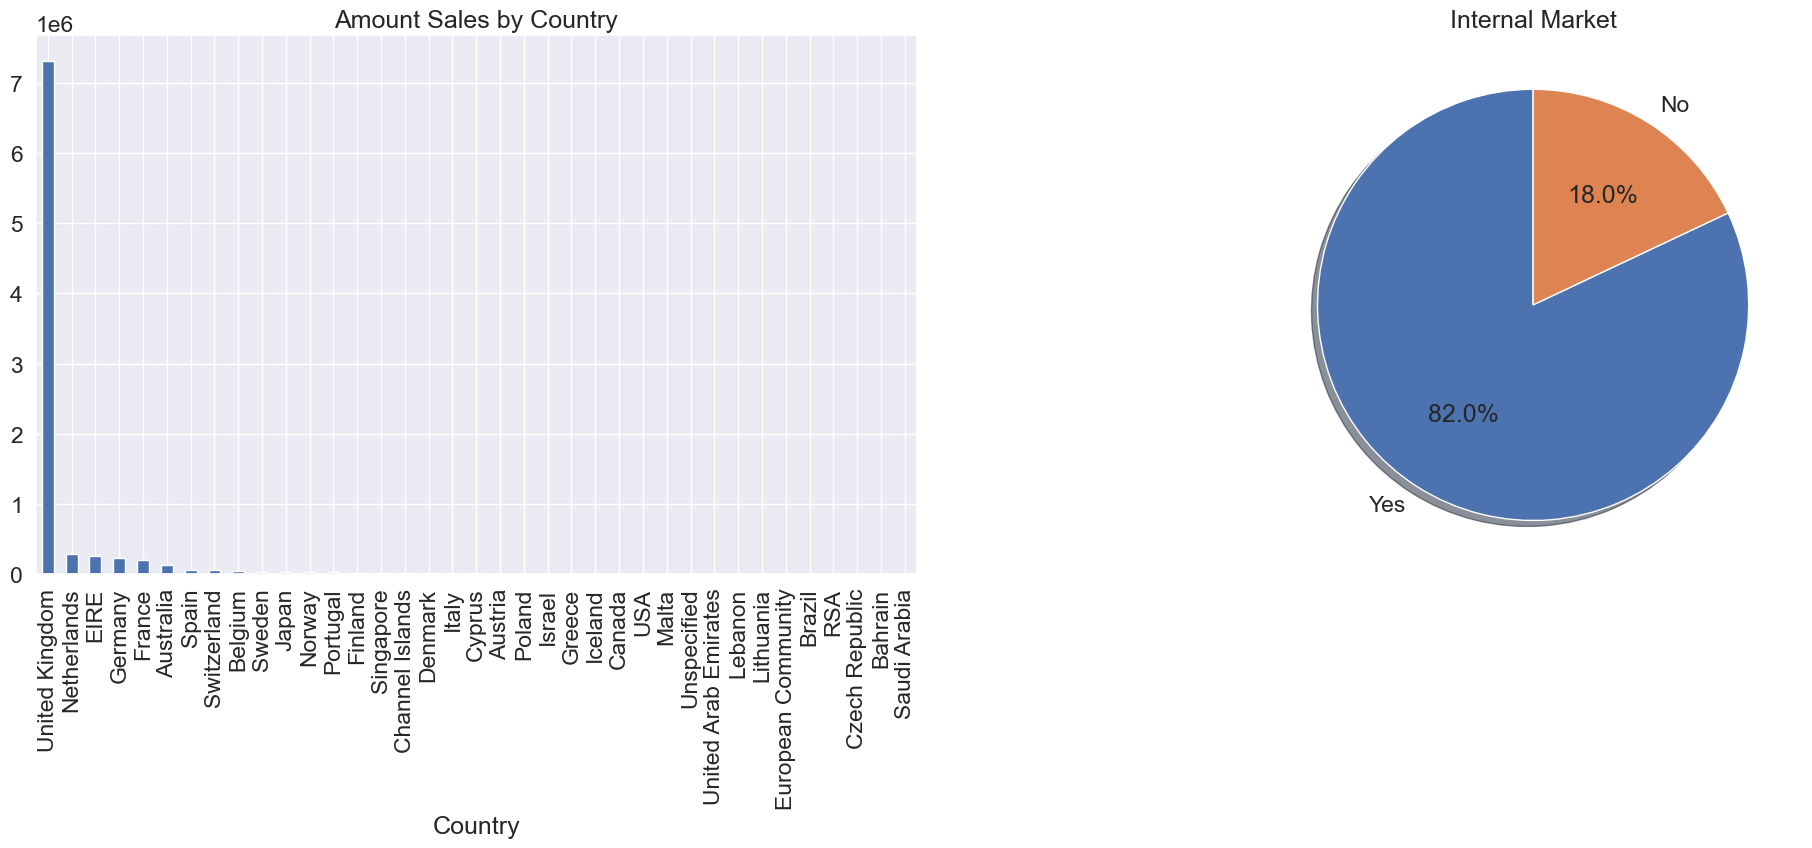

In [21]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
df['Internal'] = df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

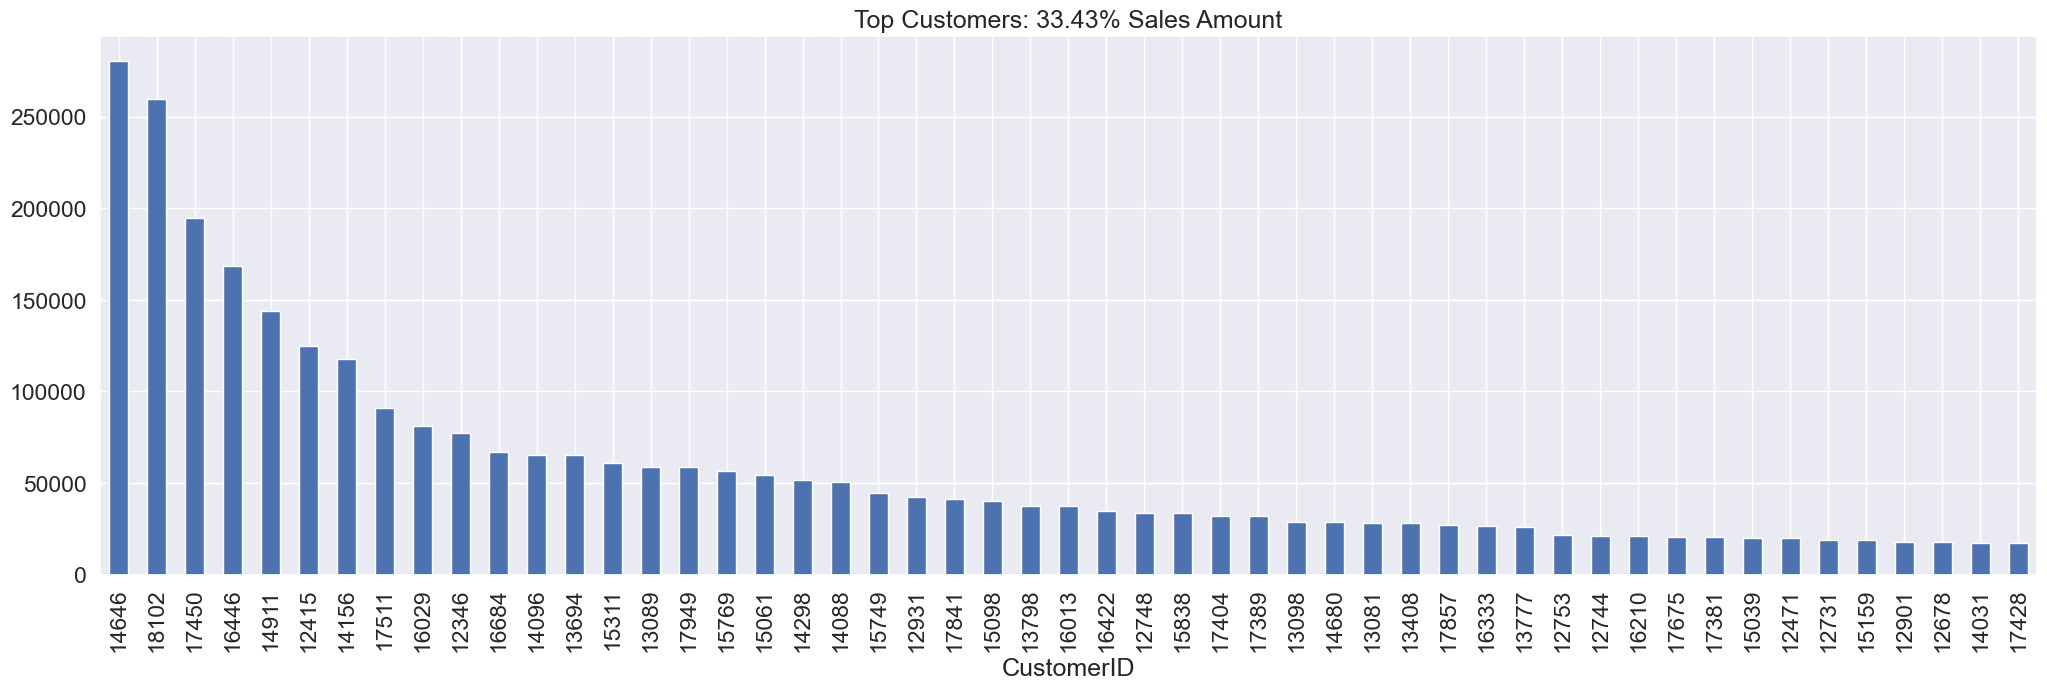

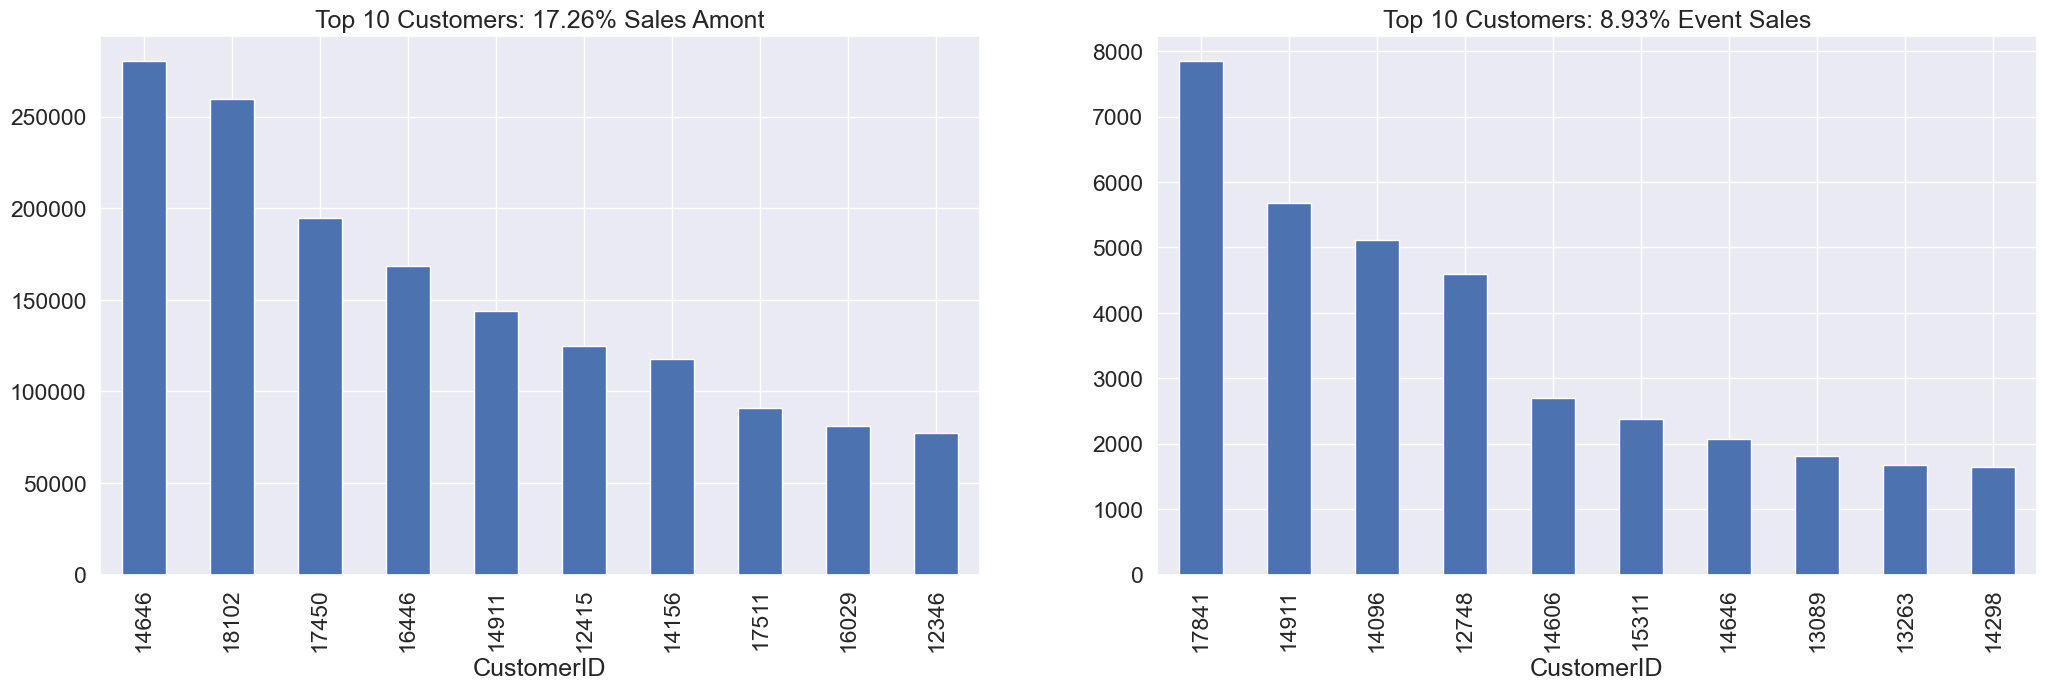

In [22]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

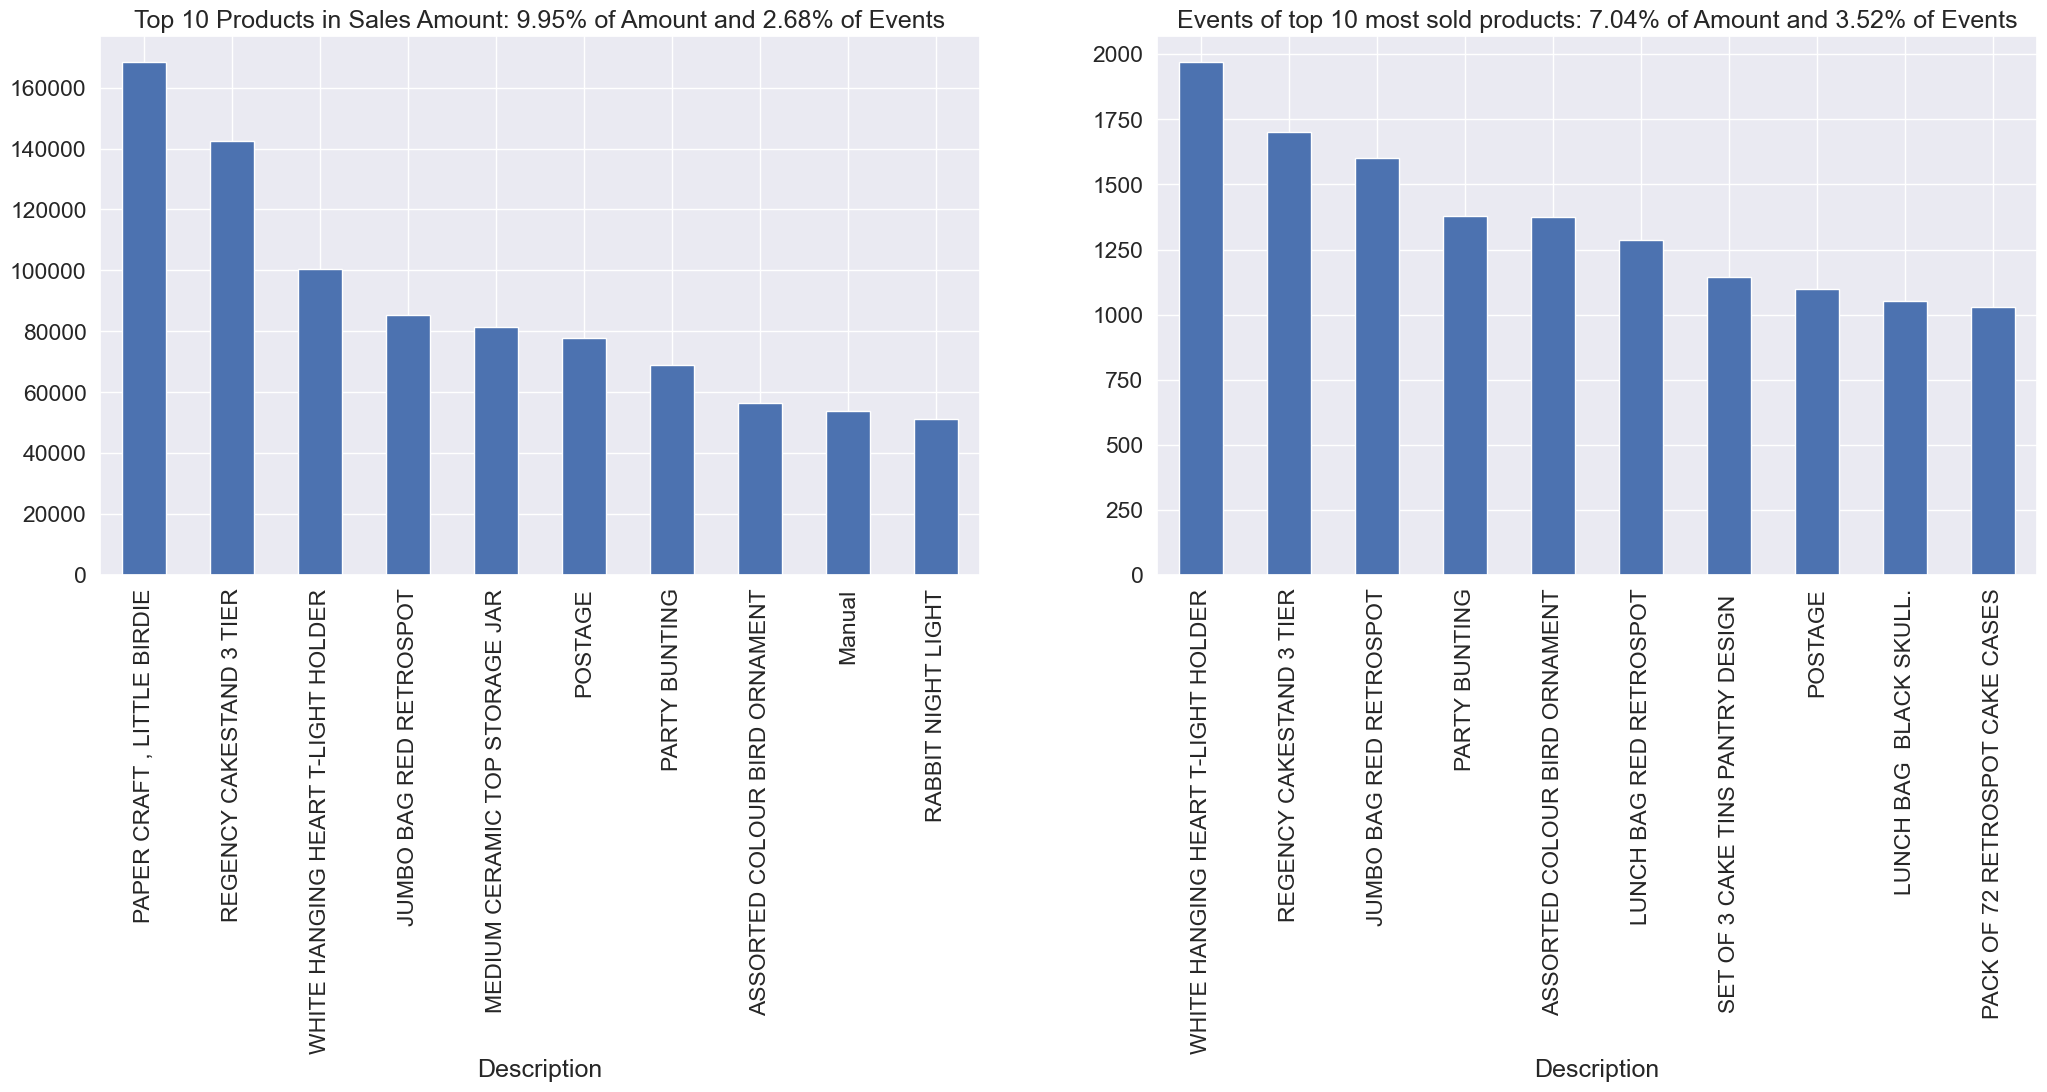

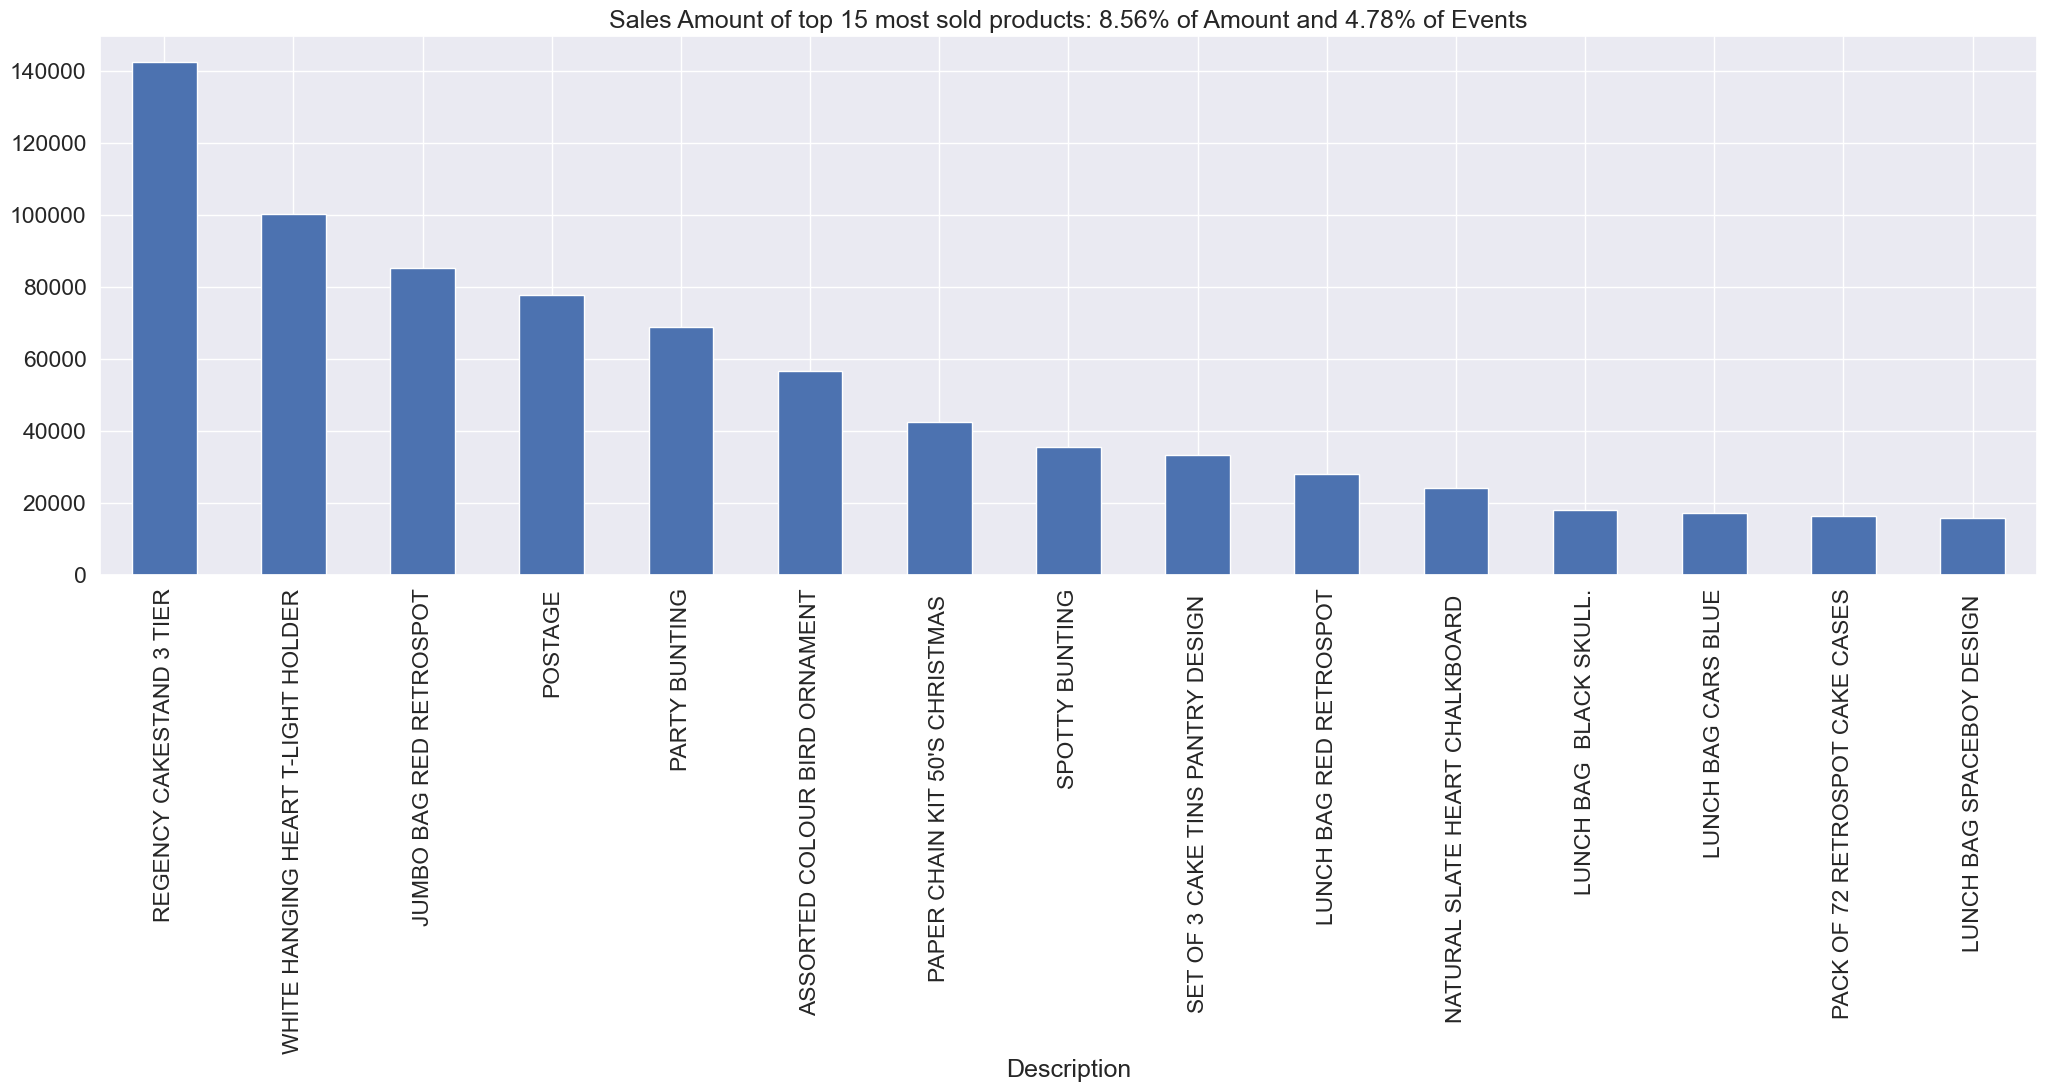

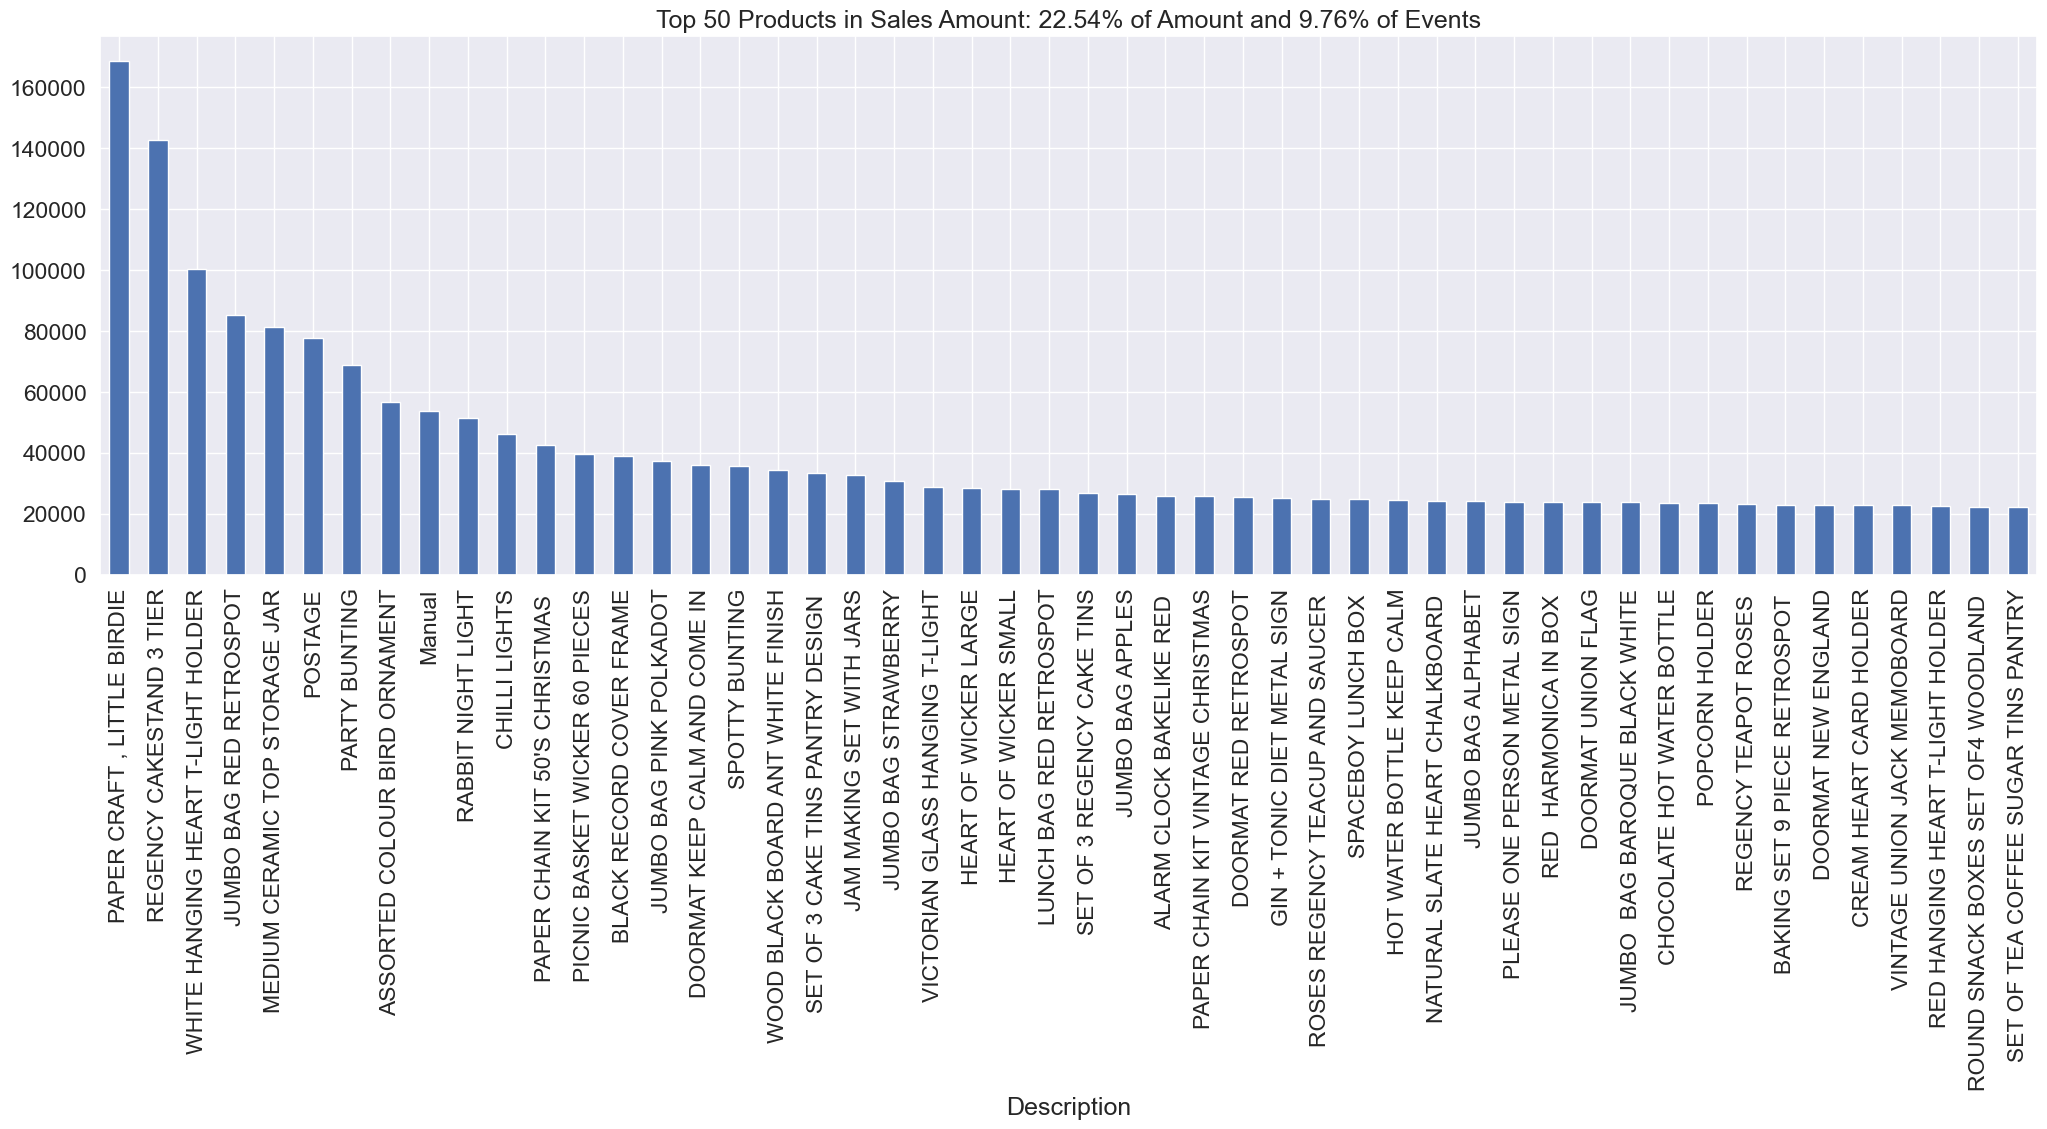

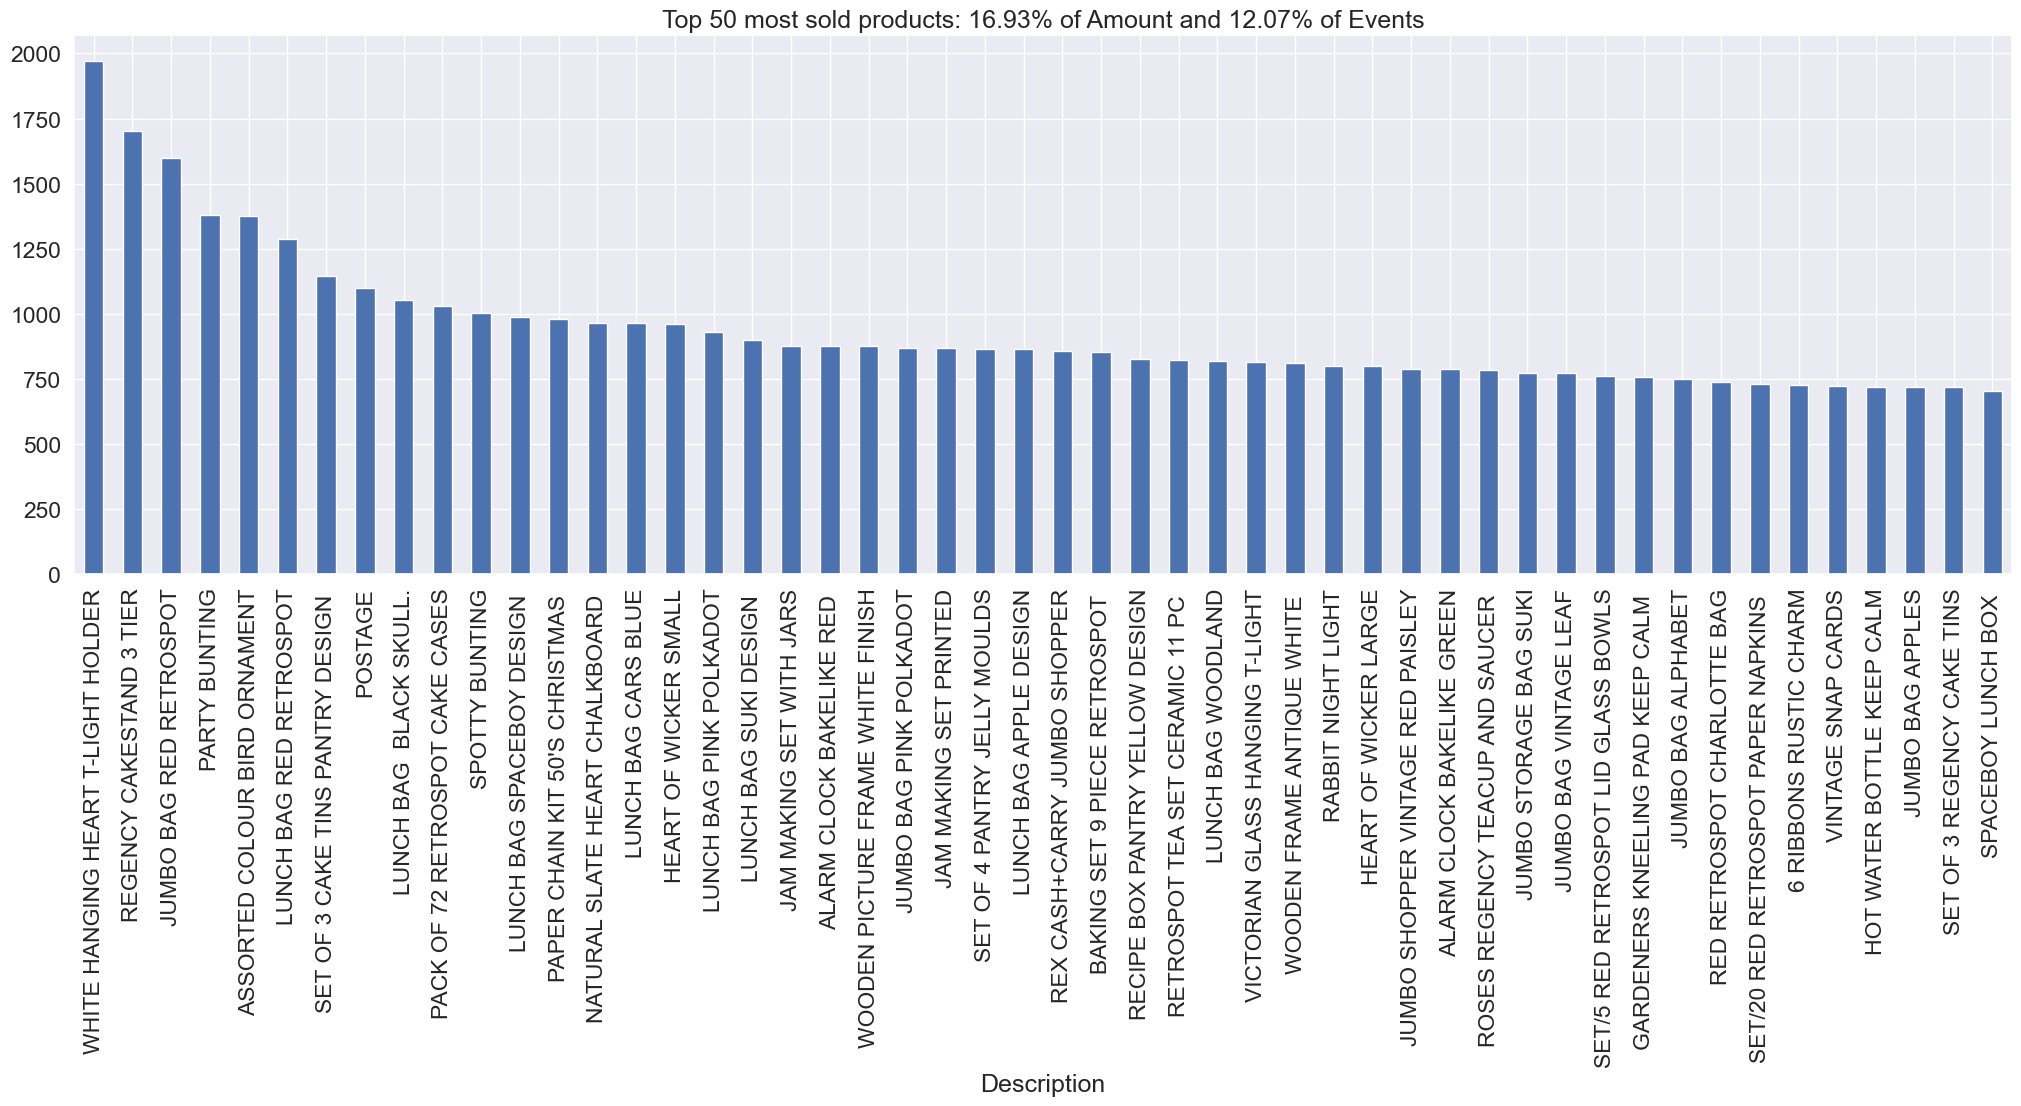

In [23]:
AmoutSum = df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

#### Customer Segmentation:
Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:

Higher Revenue: This is the most obvious requirement of any customer segmentation project.
Customer Understanding: One of the mostly widely accepted business paradigms is “know your customer” and a segmentation of the customer base allows for a perfect dissection of this paradigm.

Target Marketing: The most visible reason for customer segmentation is the ability to focus marketing efforts effectively and efficiently. If a firm knows the different segments of its customer base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.

Optimal Product Placement: A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.

Finding Latent Customer Segments: Finding out which segment of customers it might be missing to identifying untapped customer segments by focused on marketing campaigns or new business development.
#### Clustering:

The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering. The method is as simple as collecting as much data about the customers as possible in the form of features or attributes and then finding out the different clusters that can be obtained from that data. Finally, we can find traits of customer segments by analyzing the characteristics of the clusters.

Exploratory Data Analysis:

Using exploratory data analysis is another way of finding out customer segments. This is usually done by analysts who have a good knowledge about the domain relevant to both products and customers. It can be done flexibly to include the top decision points in an analysis.

RFM Model for Customer Value:
Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

##### Recency: The value of how recently a customer purchased at the establishment
##### Frequency: How frequent the customer’s transactions are at the establishment
##### Monetary value: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment
##### Recency : To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [24]:
reference_date=df.InvoiceDate.max()+datetime.timedelta(days=1)
print(reference_date)
df['days_since_last_purchase'] = (reference_date - df.InvoiceDate).dt.days
customer_history_df=df[['CustomerID','days_since_last_purchase']].groupby('CustomerID').min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'},inplace=True)


2011-12-10 12:50:00


In [25]:
customer_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0


##### We will plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

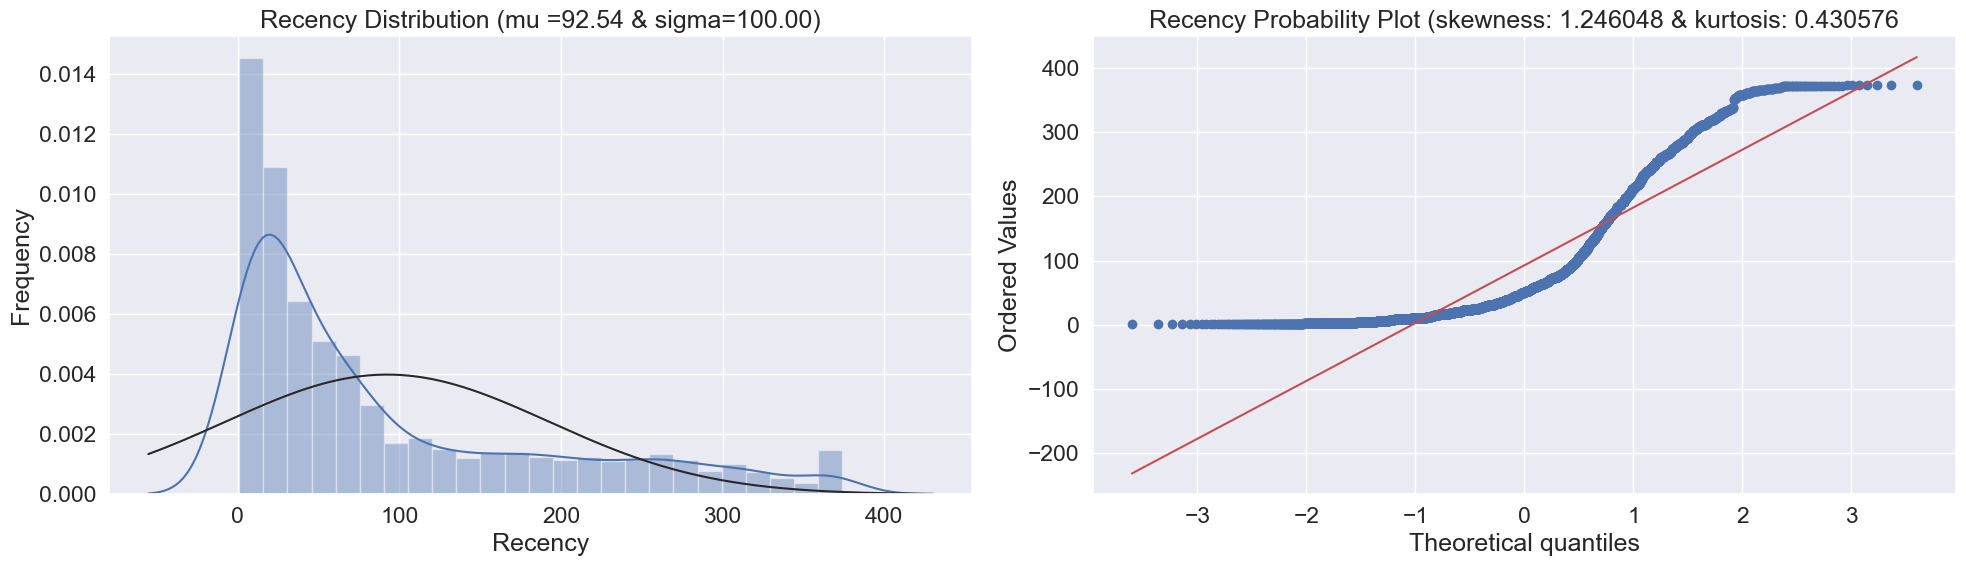

In [37]:
def qplot(data,measure):
    fig=plt.figure(figsize=(20, 6))
    
    (mu,sigma)= norm.fit(data)
    
    #kernal density plot
    fig1=fig.add_subplot(1,2,1)
    sns.distplot(data, fit=norm )
    fig1.set_title(measure +' Distribution (mu ={:.2f} & sigma={:.2f})'.format(mu,sigma),loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    # QQ plot
    fig2=fig.add_subplot(1,2,2)
    res=probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} & kurtosis: {:.6f}'.format(data.skew(),data.kurt()),loc='center')
    plt.tight_layout()
    plt.show()

qplot(customer_history_df.recency,'Recency')
    

From the first graph above we can see that sales recency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales recency also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

With skewness positive of 1.25, we confirm the lack of symmetry and indicate that sales recency are skewed right, as we can see too at the Sales Distribution plot, skewed right means that the right tail is long relative to the left tail. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 0.43 of positive kurtosis sales recency are heavy-tailed and has some outliers.

#### Frequency

In [42]:
customer_history_df

,CustomerID,recency
0,12346,326
1,12347,2
2,12348,75
3,12349,19
4,12350,310
...,...,...
4333,18280,278
4334,18281,181
4335,18282,8
4336,18283,4


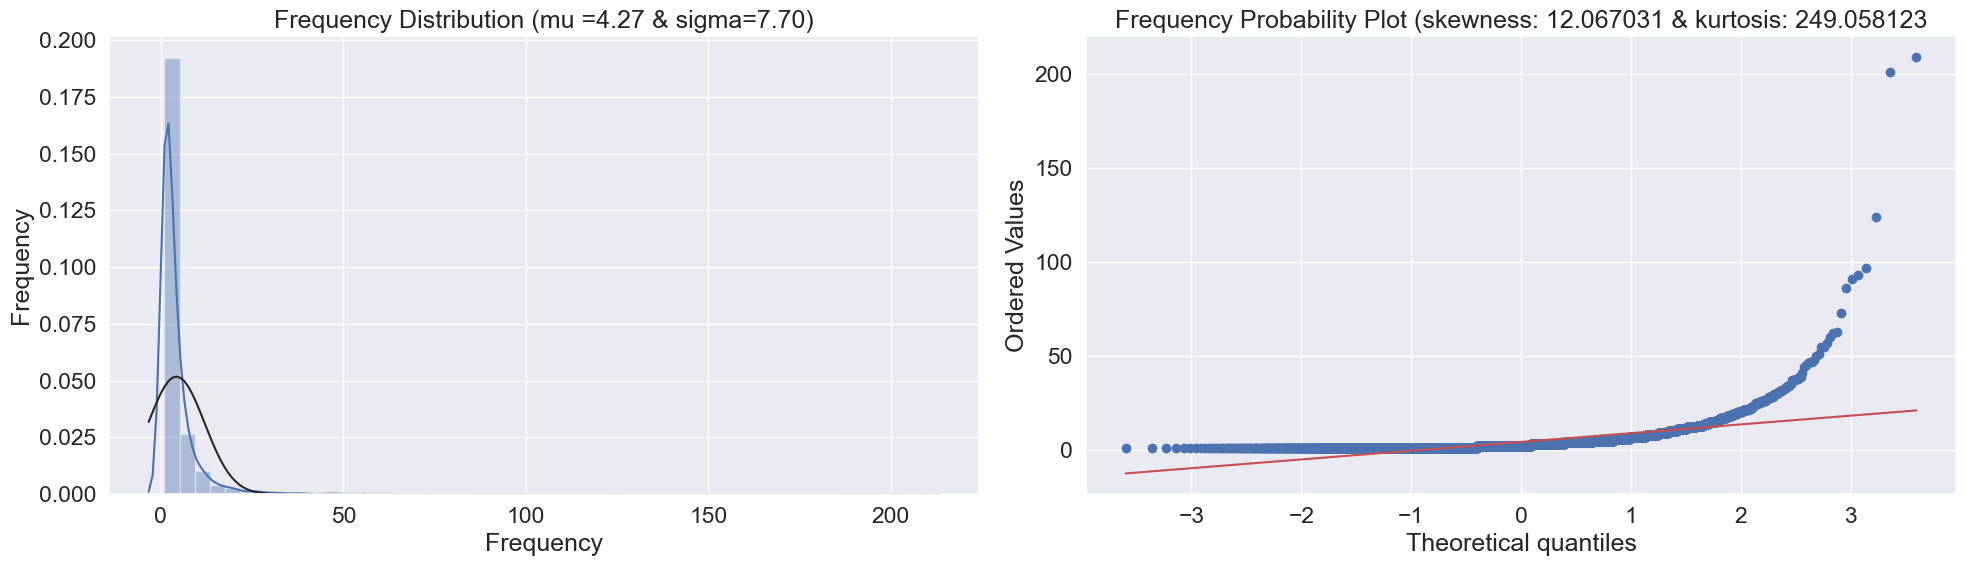

In [43]:
customer_frequency=(df[['CustomerID','InvoiceNo']].groupby(['CustomerID','InvoiceNo']).count().reset_index()) .\
    groupby(['CustomerID']).count().reset_index()
customer_frequency.rename(columns={'InvoiceNo':'Frequency'}, inplace=True)
customer_history_df=customer_history_df.merge (customer_frequency)
qplot(customer_history_df.Frequency, 'Frequency')

From the first graph above we can see that sales frequency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales frequency also does **not align with the diagonal and confirm that is a skewed right.

With skewness positive of 12.1, we confirm the high lack of symmetry and with 249 Kurtosis indicates that is a heavy-tailed distribution and has outliers.



#### Monetary Value

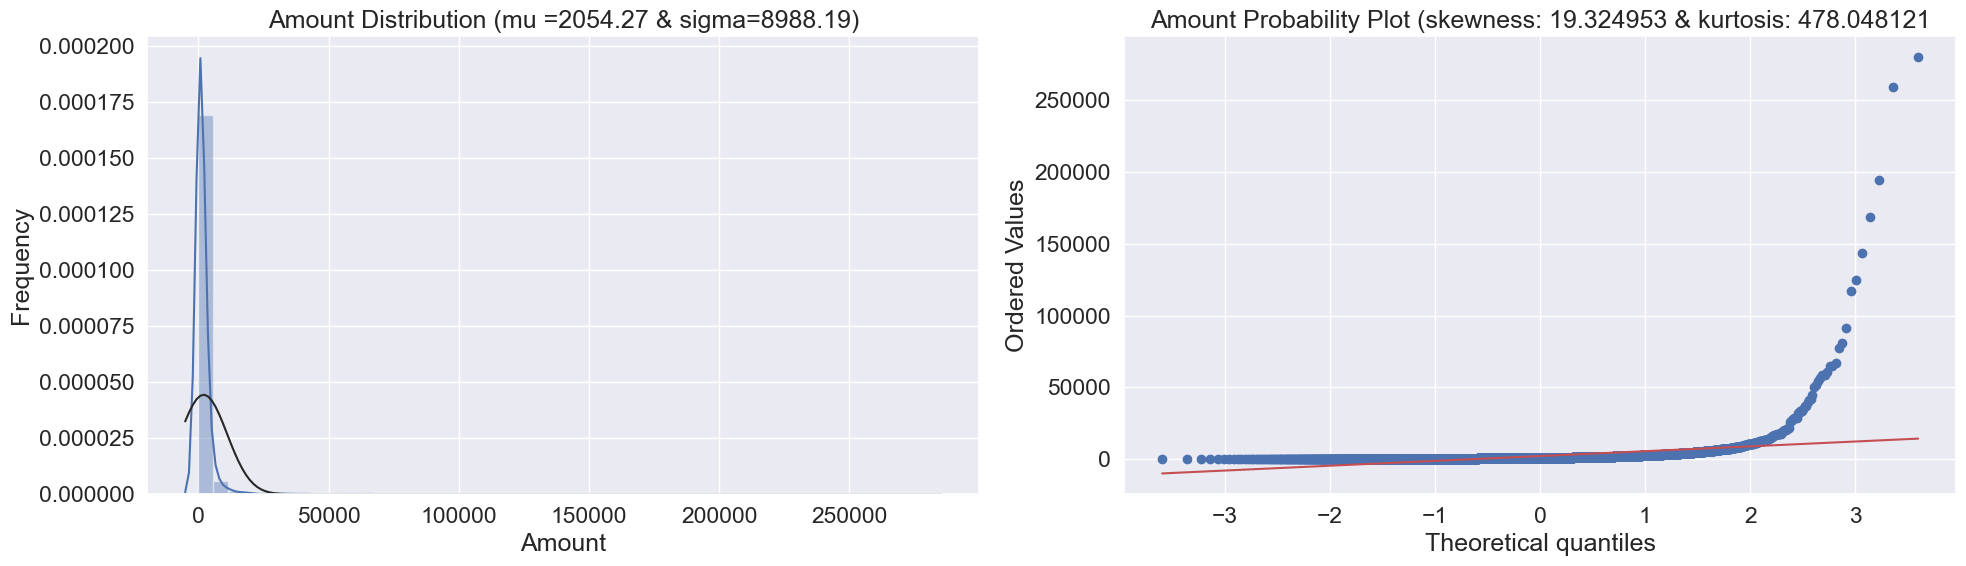

In [46]:
customer_monetary=df[['CustomerID','amount']].groupby('CustomerID').sum().reset_index()
customer_history_df=customer_history_df.merge(customer_monetary)
qplot(customer_history_df.amount,'Amount')

From the first graph above we can see that sales amount distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales amount also does not align with the diagonal, special on the right.

With skewness positive of 19.3, we confirm the high lack of symmetry and with 478 Kurtosis indicates that is a too heavy-tailed distribution and has outliers, surely more than 10 very extreme.

In [47]:
customer_history_df.describe()

,CustomerID,recency,Frequency,amount
count,4338.0,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.0,1.000000,1.000000,3.750000
25%,13813.25,18.000000,1.000000,307.415000
50%,15299.5,51.000000,2.000000,674.485000
75%,16778.75,142.000000,5.000000,1661.740000
max,18287.0,374.000000,209.000000,280206.020000


#### Data Preprocessing